In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.path import Path

import torch.nn as nn
import torch.nn.functional as F
from torch import cat
import torch
from torchvision import transforms

import torch.optim as optim
from sklearn.utils import gen_batches
import pickle

# Data Importation and Treatment

In [5]:
# Importation of the data
filename = './data/meta_data.hdf'
row_data = pd.read_hdf(filename,'/d')

print(f'There are {row_data.shape[0]} observations and each observation has {row_data.shape[1]} attributes.')

There are 37779 observations and each observation has 7 attributes.


In [6]:
# Here we merge all data (csv) together from the validation part 
all_files = ['paths_df_validated_3000_5500.csv', 'paths_df_validated_5500_6500.csv']
final_data = pd.DataFrame()

for file in all_files : 
    temp = pd.read_csv(file)
    temp = temp.loc[temp['valid'] == True] #Select only the 'True' = Validated images
    final_data = pd.concat([final_data,temp],axis=0) #Concatenate the information in one dataframe

# We select the images from row_data with the index of the validation part (final_data)
index_name = final_data['original_index'].values    # Select the index
data = row_data.iloc[index_name]                    # Extract the validated images

print(f'There are {data.shape[0]} validated observations and each observation has {data.shape[1]} attributes.')

There are 1620 validated observations and each observation has 7 attributes.


In [7]:
# This bloc checks if the selected images are the good ones
n_match = (final_data['mask_path'].values == data['building_id'].values).sum()
if n_match == data.shape[0] :
    print('All is good with the dataset, we can continue !')
else : 
    print('There is a mismatch between pictures (pictures names)')

All is good with the dataset, we can continue !


In [9]:
# This function plots the surface polygons of the selected image 
def image_reader (image_data) : 
    surfaces = image_data.b_surfaces
    # One polygone
    if (len(surfaces[0])==2) : 
        plt.plot(np.array(surfaces)[:,1],np.array(surfaces)[:,0], label = 'surface', c = 'r')
    # Multiples polygones
    else :
        for polygons in surfaces : 
            plt.plot(np.array(polygons)[:,1],np.array(polygons)[:,0], label = 'surface', c = 'r')
    return 0

c40c059e-4466-4257-bcec-3ceff2ed5d4a-b15-otovowms.jpeg


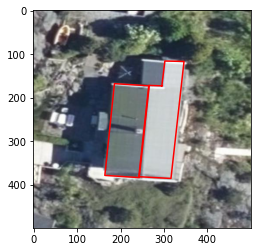

In [10]:
n = 1
for i in range (n) : 
    a = data.iloc[i]
    im_name = a.building_id +  '-b15-otovowms.jpeg'
    print(im_name)
    im_matrix = plt.imread('./data/' + im_name)
    plt.imshow(im_matrix)
    image_reader(a)
    plt.show()

In [11]:
# This function creates the mask for one image 
def mask_creation (n,p,surfaces) : 
    # One polygone
    if (len(surfaces[0])==2) : 
        x, y = np.meshgrid(np.arange(n), np.arange(p))
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x,y)).T
        path = Path(surfaces)
        grid = path.contains_points(points)
        grid = grid.reshape((n,p))
    # Multiples polygones
    else :
        grid = np.reshape([False for i in range (n*p)],(n,p))
        for i,polygons in enumerate(surfaces) : 
            x, y = np.meshgrid(np.arange(n), np.arange(p))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(polygons)
            grid_2 = path.contains_points(points)
            grid_2 = grid_2.reshape((n,p))
            grid = np.add(grid,grid_2)
    
    # We reshape the grid before exporting 
    return (grid)

In [12]:
from tqdm import tqdm 

# This function creates a format that will be use for the DL Network
def creation_useful_dataset(dataset) : 
    X=[]; Y=[];
    length,_ = dataset.shape
    n = 500; p = 500; # Image Shape
    for i in tqdm(range(length)) :
        info = dataset.iloc[i]
        image_name = info.building_id + '-b15-otovowms.jpeg'
        im_matrix = plt.imread('./data/' + image_name)
        # We build the X_dataset 
        X.append(im_matrix)
        # We build the target_dataset
        surfaces = info.b_surfaces
        Y.append(mask_creation(n,p,surfaces))
    X = torch.Tensor(np.array(X))
    X = torch.swapaxes(X, 1, -1)  # To have (B,C,H,W)
    Y = torch.Tensor(np.array(Y)) 
    return (X,Y)

In [14]:
n_split = int(data.shape[0]*0.8) # 80% training and 20% testing 
df_train = data.iloc[:n_split]
df_test = data.iloc[n_split:]

print('Importation of the Training set')
X_train, Y_train = creation_useful_dataset(df_train)
print('Importation of the Testing set')
X_test, Y_test = creation_useful_dataset(df_test)

Importation of the Training set


100%|███████████████████████████████████████| 1296/1296 [02:16<00:00,  9.47it/s]


Importation of the Testing set


100%|█████████████████████████████████████████| 324/324 [00:33<00:00,  9.66it/s]


In [ ]:
# Dump the data into a pickle file
with open('./pickles/data.X_train', 'wb') as f:
     pickle.dump(X_train, f)
with open('./pickles/data.Y_train', 'wb') as f:
     pickle.dump(Y_train, f)
with open('./pickles/data.X_test', 'wb') as f:
     pickle.dump(X_test, f)
with open('./pickles/data.Y_test', 'wb') as f:
     pickle.dump(Y_test, f)

**Data Augmentation** 

We can shift the image 90°,180°,270° to have more images to train on.

# Deep Learning Network 

In [5]:
# Load the data from a pickle file
with open('./pickles/data.X_train', 'rb') as f:
     X_train = pickle.load(f)
with open('./pickles/data.Y_train', 'rb') as f:
     Y_train = pickle.load(f)
with open('./pickles/data.X_test', 'rb') as f:
     X_test = pickle.load(f)
with open('./pickles/data.Y_test', 'rb') as f:
     Y_test = pickle.load(f)

In [6]:
print(f'X_train : {X_train.shape} - [Batchsize,Channel,Height,Width]')
print(f'Y_train : {Y_train.shape} - [Batchsize,Height,Width]')
print(f'X_test : {X_test.shape} - [Batchsize,Channel,Height,Width]')
print(f'Y_test : {Y_test.shape} - [Batchsize,Height,Width]')

[Batchsize,Channel,Height,Width] or [Batchsize,Height,Width]
X_train : torch.Size([1296, 3, 500, 500])
Y_train : torch.Size([1296, 500, 500])
X_test : torch.Size([324, 3, 500, 500])
Y_test : torch.Size([324, 500, 500])


In [83]:
## For testing the code 
df_train = data.iloc[:10]
df_test = data.iloc[10:12]
print('Importation of the Training set')
X_train, Y_train = creation_useful_dataset(df_train)
print('Importation of the Testing set')
X_test, Y_test = creation_useful_dataset(df_test)

Importation of the Training set


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.42it/s]


Importation of the Testing set


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.22it/s]


In [85]:
class UNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Contracting Path
        self.conv11 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv21 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv31 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv41 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.conv42 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv51 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3, stride=1, padding=1)
        self.conv52 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)

        # Expanding Path
        self.up5 = nn.Upsample(size=(62,62))
        self.conv53 = nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.conv61 = nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.conv62 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3, stride=1, padding=1)
        self.up6 = nn.Upsample(size=(125,125))
        self.conv63 = nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.conv71 = nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.conv72 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3, stride=1, padding=1)
        self.up7 = nn.Upsample(size=(250,250))
        self.conv73 = nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.conv81 = nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.conv82 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3, stride=1, padding=1)
        self.up8 = nn.Upsample(size=(500,500))
        self.conv83 = nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv91 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.conv92 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3, stride=1, padding=1)
        self.conv93 = nn.Conv2d(in_channels=64,out_channels=2,kernel_size=3, stride=1, padding=1)

        # Output
        self.conv10 = nn.Conv2d(in_channels=2,out_channels=1,kernel_size=1)

    def forward(self, x):
        # Contracting Path
        x1 = F.relu(self.conv11(x))
        x1 = F.relu(self.conv12(x1))
        
        x2 = self.pool1(x1)
        x2 = F.relu(self.conv21(x2))
        x2 = F.relu(self.conv22(x2))
        
        x3 = self.pool2(x2)
        x3 = F.relu(self.conv31(x3))
        x3 = F.relu(self.conv32(x3))
        
        x4 = self.pool3(x3)
        x4 = F.relu(self.conv41(x4))
        x4 = F.relu(self.conv42(x4))
        
        x5 = self.pool4(x4)
        x5 = F.relu(self.conv51(x5))
        x5 = F.relu(self.conv52(x5))

        # Expanding Path
        x5 = self.up5(x5)
        x6 = self.conv53(x5)
        x4 = transforms.CenterCrop(62)(x4)
        x6 = cat([x4, x6], axis=1)
        x6 = F.relu(self.conv61(x6))
        x6 = F.relu(self.conv62(x6))
        
        x6 = self.up6(x6)
        x7 = self.conv63(x6)
        x3 = transforms.CenterCrop(125)(x3)
        x7 = cat([x3, x7], axis=1)
        x7 = F.relu(self.conv71(x7))
        x7 = F.relu(self.conv72(x7))
        
        x7 = self.up7(x7)
        x8 = self.conv73(x7)
        x2 = transforms.CenterCrop(250)(x2)
        x8 = cat([x2, x8], axis=1)
        x8 = F.relu(self.conv81(x8))
        x8 = F.relu(self.conv82(x8))
        
        x8 = self.up8(x8)
        x9 = self.conv83(x8)
        x1 = transforms.CenterCrop(500)(x1)
        x9 = cat([x1, x9], axis=1)      
        x9 = F.relu(self.conv91(x9))
        x9 = F.relu(self.conv92(x9))
        x9 = F.relu(self.conv93(x9))

        # Output
        x10 = self.conv10(x9)
        x10 = torch.sigmoid(x10) #F.sigmoid(x10)
        return x10

In [86]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        # Intersection is equivalent to True Positive count
        # Union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        IoU = (intersection + smooth)/(union + smooth)
        return 1 - IoU

In [87]:
net = UNetV2()
criterion = IoULoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6)

In [ ]:
from sklearn.utils import gen_batches

# Batch Creation
batch_size = 2
batches_index_train = list(gen_batches(X_train.shape[0],batch_size=batch_size))

for epoch in range(2) : # loop over the dataset multiple times
    print(f'Epoch n°{epoch}')
    for i in tqdm(range(len(batches_index_train))) : 
        batch_slice = batches_index_train[i]
        # get the inputs; data is a list of [inputs, labels]
        inputs, masks = X_train[batch_slice], Y_train[batch_slice]
        # zero the parameter gradients
        optimizer.zero_grad()
        # Step : forward + backward + optimize
        outputs = torch.squeeze(net(inputs),dim=1)     # To reduce the dimension to [B,H,W] of outputs
        outputs = (outputs>0.5)*1                      # From probabilities to [0,1] for mask and loss computation
        # Computation of loss function
        loss = criterion(outputs, masks)               # Compute 1-IoT as loss value 
        loss.requires_grad = True
        loss.backward()                                # Backward of loss function
        optimizer.step()                               # We optimize the network

Epoch n°0


 80%|████████████████████████████████████         | 4/5 [01:33<00:22, 22.35s/it]

In [ ]:
# Pickle the model 
with open('./pickles/cnn_model', 'wb') as f:
     pickle.dump(net, f)

# To do list :

**Optimizer :** We can try with different optimizers to see some differences.

**Batch :** Export and Import batch data for each epoch to use less memory.

**Metrics :** We can use intersection over union (IoU) with the masks, AUC, position recall curve.

**Expansion of the model :** We can test the model on unseen data to see if it can be generalized.

# Old Code

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Contracting Path
        self.conv11 = nn.Conv2d(3, 64, 3)
        self.conv12 = nn.Conv2d(64, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv21 = nn.Conv2d(64, 128, 3)
        self.conv22 = nn.Conv2d(128, 128, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv31 = nn.Conv2d(128, 256, 3)
        self.conv32 = nn.Conv2d(256, 256, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv41 = nn.Conv2d(256, 512, 3)
        self.conv42 = nn.Conv2d(512, 512, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv51 = nn.Conv2d(512, 1024, 3)
        self.conv52 = nn.Conv2d(1024, 1024, 3)
        self.pool5 = nn.MaxPool2d(2, 2)

        # Expanding Path
        self.up5 = nn.Upsample(size=(46,46))
        self.conv53 = nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.conv61 = nn.Conv2d(1024, 512, 3)
        self.conv62 = nn.Conv2d(512, 512, 3)
        self.up6 = nn.Upsample(size=(84,84))
        self.conv63 = nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.conv71 = nn.Conv2d(512, 256, 3)
        self.conv72 = nn.Conv2d(256, 256, 3)
        self.up7 = nn.Upsample(size=(160,160))
        self.conv73 = nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.conv81 = nn.Conv2d(256, 128, 3)
        self.conv82 = nn.Conv2d(128, 128, 3)
        self.up8 = nn.Upsample(size=(312,312))
        self.conv83 = nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv91 = nn.Conv2d(128, 64, 3)
        self.conv92 = nn.Conv2d(64, 64, 3)
        self.conv93 = nn.Conv2d(64, 2, 3)

        # Output
        self.conv10 = nn.Conv2d(2, 1, 1)

    def forward(self, x):
        # Contracting Path
        print(x.shape)
        x1 = F.relu(self.conv11(x))
        x1 = F.relu(self.conv12(x1))
        print('x1 : ', x1.shape)
        
        x2 = self.pool1(x1)
        x2 = F.relu(self.conv21(x2))
        x2 = F.relu(self.conv22(x2))
        print('x2 : ', x2.shape)
        
        x3 = self.pool2(x2)
        x3 = F.relu(self.conv31(x3))
        x3 = F.relu(self.conv32(x3))
        print('x3 : ', x3.shape)
        
        x4 = self.pool3(x3)
        x4 = F.relu(self.conv41(x4))
        x4 = F.relu(self.conv42(x4))
        print('x4 : ', x4.shape)
        
        x5 = self.pool4(x4)
        x5 = F.relu(self.conv51(x5))
        x5 = F.relu(self.conv52(x5))
        print('x5 : ', x5.shape)

        # Expanding Path
        x5 = self.up5(x5)
        x6 = self.conv53(x5)
        x4 = transforms.CenterCrop(46)(x4)
        x6 = cat([x4, x6], axis=1)
        x6 = F.relu(self.conv61(x6))
        x6 = F.relu(self.conv62(x6))
        print('x6 : ', x6.shape)
        
        x6 = self.up6(x6)
        x7 = self.conv63(x6)
        x3 = transforms.CenterCrop(84)(x3)
        x7 = cat([x3, x7], axis=1)
        x7 = F.relu(self.conv71(x7))
        x7 = F.relu(self.conv72(x7))
        print('x7 : ', x7.shape)
        
        x7 = self.up7(x7)
        x8 = self.conv73(x7)
        x2 = transforms.CenterCrop(160)(x2)
        x8 = cat([x2, x8], axis=1)
        x8 = F.relu(self.conv81(x8))
        x8 = F.relu(self.conv82(x8))
        print('x8 : ', x8.shape)
        
        x8 = self.up8(x8)
        x9 = self.conv83(x8)
        x1 = transforms.CenterCrop(312)(x1)
        x9 = cat([x1, x9], axis=1)      
        x9 = F.relu(self.conv91(x9))
        x9 = F.relu(self.conv92(x9))
        x9 = F.relu(self.conv93(x9))
        print('x9 : ', x9.shape)

        # Output
        x10 = self.conv10(x9)
        print('x10p1 : ', x10.shape)
        x10 = F.sigmoid(x10)
        return x10

net = UNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99)


In [ ]:
from sklearn.utils import gen_batches

# Batch Creation
batch_size = 10
batches_index_train = list(gen_batches(X_train.shape[0],batch_size=batch_size))

for epoch in range(2) : # loop over the dataset multiple times
    print(f'Epoch n°{epoch}')
    # running_loss = 0.0
    for i in tqdm(range(len(batches_index_train))) : 
        batch_slice = batches_index_train[i]
        # get the inputs; data is a list of [inputs, labels]
        inputs, masks = X_train[batch_slice], Y_train[batch_slice]
        # zero the parameter gradients
        optimizer.zero_grad()
        # Step : forward + backward + optimize
        outputs = torch.squeeze(net(inputs),dim=1)     # To reduce the dimension to [B,H,W] of outputs
        outputs = (outputs>0.5)*1                      # From probabilities to [0,1] for mask and loss computation
        # Computation of loss function
        loss = criterion(outputs, masks)               # Compute 1-IoT as loss value 
        loss.requires_grad = True
        loss.backward()                                # Backward of loss function
        optimizer.step()                               # We optimize the network
        # print statistics
        # running_loss += loss.item()
        # if i%2==1 : 
        #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3f}')
        #    running_loss = 0.0